# Citation

@inproceedings{wilie2020indonlu,
  title={IndoNLU: Benchmark and Resources for Evaluating Indonesian Natural Language Understanding},
  author={Bryan Wilie and Karissa Vincentio and Genta Indra Winata and Samuel Cahyawijaya and X. Li and Zhi Yuan Lim and S. Soleman and R. Mahendra and Pascale Fung and Syafri Bahar and A. Purwarianti},
  booktitle={Proceedings of the 1st Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics and the 10th International Joint Conference on Natural Language Processing},
  year={2020}
}

# Initializing

Importing Files from Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # To access gdrive files

Mounted at /content/drive


Download necessary libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.2 MB/s 
     |████████████████████████████████| 596 kB 62.7 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Import the necessary libraries

In [ ]:
import os, sys
sys.path.append('../')
os.chdir('../')

import random
import numpy as np
import pandas as pd

import torch
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from sklearn.metrics import classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Import personal libraries

In [ ]:
py_file_location = "/content/drive/MyDrive"
sys.path.append(os.path.abspath(py_file_location))

from forward_fn import forward_sequence_classification
from data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from metrics import document_sentiment_metrics_fn

Loading Tokenizer and model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing Dataset

In [ ]:
train_dataset = DocumentSentimentDataset('/content/drive/MyDrive/Training.tsv', tokenizer, lowercase=True)
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  

valid_dataset = DocumentSentimentDataset('/content/drive/MyDrive/Valid.tsv', tokenizer, lowercase=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  

test_dataset = DocumentSentimentDataset('/content/drive/MyDrive/Testing.tsv', tokenizer, lowercase=True)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating a test CSV

In [ ]:
tsv_files = '/content/drive/MyDrive/Testing.tsv'
csv_table = pd.read_table(tsv_files,sep='\t')
csv_table.to_csv('x_test.csv',index=False)

x_test = pd.read_csv('x_test.csv',names = ['Review','Sentiment'])

Check Indobert labels

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

# We changed the label:
# - Removed neutral labels
# - Changed negative label from 2 -> 1

{'positive': 0, 'negative': 1}
{0: 'positive', 1: 'negative'}


In [ ]:
def indo_sentiment(sentence):
  subwords = tokenizer.encode(sentence)
  subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

  logits = model(subwords)[0]
  label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

  return logits, label

# Before Fine Tuning

In [ ]:
example_sentence = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'

logits, label = indo_sentiment(example_sentence)

print(f'Text: {example_sentence} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (70.896%)


In [ ]:
df = pd.DataFrame()
df['indobert'] = ''
df['indobert_before'] = ''
df['indobert_after'] = ''

In [ ]:
df_temp = pd.DataFrame()
df_temp['indobert'] = ''
df_temp['before'] = ''
df_temp['after'] = ''

In [ ]:
%%time
count = 0

for i, reviews in enumerate(x_test['Review']):
  logits, label = indo_sentiment(reviews)

  if(i2w[label] == x_test.at[i,'Sentiment']):
    count+=1

  if x_test.at[i,'Sentiment'] == 'positive':
    df.at[i, 'indobert'] = int(1)
    df_temp.at[i, 'indobert'] = "positive"
  else:
    df.at[i, 'indobert'] = int(0)
    df_temp.at[i, 'indobert'] = "negative"

  if i2w[label] == 'positive':
    df.at[i, 'indobert_before'] = int(1)
    df_temp.at[i, 'before'] = "positive"
  else:
    df.at[i, 'indobert_before'] = int(0)
    df_temp.at[i, 'before'] = "negative"

accuracy = count/len(x_test)

print("Indobert accuracy before fine tuning: " + str(accuracy))

Indobert accuracy before fine tuning: 0.48148148148148145
CPU times: user 49.4 s, sys: 336 ms, total: 49.7 s
Wall time: 52 s


In [ ]:
df_temp

,indobert,before,after
0,positive,positive,NaN
1,positive,positive,NaN
2,negative,positive,NaN
3,negative,positive,NaN
4,positive,positive,NaN
...,...,...,...
535,negative,positive,NaN
536,positive,positive,NaN
537,positive,positive,NaN
538,positive,positive,NaN


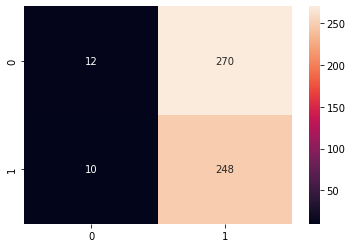

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt   

cm = confusion_matrix(df_temp['indobert'], df_temp['before'])
f = sns.heatmap(cm, annot=True)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
df['indobert'] = df['indobert'].astype(int)
df['indobert_before'] = df['indobert_before'].astype(int)

In [ ]:
print(str(df.isnull().sum()))

indobert             0
indobert_before      0
indobert_after     540
dtype: int64


In [ ]:
print(classification_report(df['indobert'], df['indobert_before']))

              precision    recall  f1-score   support

           0       0.55      0.04      0.08       282
           1       0.48      0.96      0.64       258

    accuracy                           0.48       540
   macro avg       0.51      0.50      0.36       540
weighted avg       0.51      0.48      0.35       540



# Fine Tuning

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
%%time
# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 1) TRAIN LOSS:0.3646 LR:0.00000300: 100%|██████████| 135/135 [00:34<00:00,  3.86it/s]


(Epoch 1) TRAIN LOSS:0.3646 ACC:0.85 F1:0.85 REC:0.85 PRE:0.85 LR:0.00000300


  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2136 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 17/17 [00:03<00:00,  5.11it/s]


(Epoch 1) VALID LOSS:0.2136 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 2) TRAIN LOSS:0.2160 LR:0.00000300: 100%|██████████| 135/135 [00:36<00:00,  3.65it/s]


(Epoch 2) TRAIN LOSS:0.2160 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92 LR:0.00000300


  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.1879 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93: 100%|██████████| 17/17 [00:03<00:00,  4.74it/s]


(Epoch 2) VALID LOSS:0.1879 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93


  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 3) TRAIN LOSS:0.1766 LR:0.00000300: 100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


(Epoch 3) TRAIN LOSS:0.1766 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93 LR:0.00000300


  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.1782 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


(Epoch 3) VALID LOSS:0.1782 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93


  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 4) TRAIN LOSS:0.1454 LR:0.00000300: 100%|██████████| 135/135 [00:40<00:00,  3.32it/s]


(Epoch 4) TRAIN LOSS:0.1454 ACC:0.95 F1:0.95 REC:0.95 PRE:0.95 LR:0.00000300


  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.1876 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]


(Epoch 4) VALID LOSS:0.1876 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92


  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 5) TRAIN LOSS:0.1191 LR:0.00000300: 100%|██████████| 135/135 [00:39<00:00,  3.44it/s]


(Epoch 5) TRAIN LOSS:0.1191 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00000300


  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.1798 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92: 100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

(Epoch 5) VALID LOSS:0.1798 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92
CPU times: user 2min, sys: 42.9 s, total: 2min 43s
Wall time: 3min 29s


In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 17/17 [00:02<00:00,  5.86it/s]


# After Fine Tuning

In [ ]:
example_sentence = 'Pengiriman super cepat'

logits, label = indo_sentiment(example_sentence)

print(f'Text: {example_sentence} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pengiriman super cepat | Label : positive (98.720%)


In [ ]:
count = 0

for i, reviews in enumerate(x_test['Review']):
  logits, label = indo_sentiment(reviews)

  if(i2w[label] == x_test.at[i,'Sentiment']):
    count+=1

  if i2w[label] == 'positive':
    df.at[i, 'indobert_after'] = int(1)
    df_temp.at[i, 'after'] = "positive"
  else:
    df.at[i, 'indobert_after'] = int(0)
    df_temp.at[i, 'after'] = "negative"

accuracy = count/len(x_test)

print("Indobert accuracy after fine tuning: " + str(accuracy))

Indobert accuracy after fine tuning: 0.9148148148148149


In [ ]:
df['indobert_after'] = df['indobert_after'].astype(int)

In [ ]:
df

,indobert,indobert_before,indobert_after
0,1,1,1
1,1,1,1
2,0,1,0
3,0,1,0
4,1,1,1
...,...,...,...
535,0,1,0
536,1,1,0
537,1,1,1
538,1,1,1


In [ ]:
df_temp

,indobert,before,after
0,positive,positive,positive
1,positive,positive,positive
2,negative,positive,negative
3,negative,positive,negative
4,positive,positive,positive
...,...,...,...
535,negative,positive,negative
536,positive,positive,negative
537,positive,positive,positive
538,positive,positive,positive


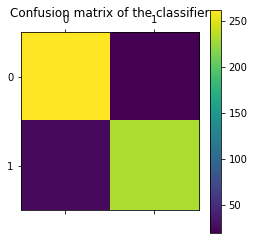

In [ ]:
cm = confusion_matrix(df_temp['indobert'], df_temp['after'])
f = sns.heatmap(cm, annot=True)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print(classification_report(df['indobert'], df['indobert_after']))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       282
           1       0.93      0.90      0.92       258

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540



In [ ]:
from google.colab import files
df.to_csv('result_indobert.csv') 
files.download('result_indobert.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>